In [1]:
"""
Necessary modules
"""
import sys, os
%load_ext autoreload
%autoreload 2 # autoreload to debug/modify modules
import numpy as np
from graphs.my_graph import * # my custom module for ~nice plots
%matplotlib inline

In [2]:
"""
Loading a sample datafile
"""
from data_analysis.IO.load_data import load_file
data = load_file('../sparse_vs_balanced/sparse_vs_balanced/data/Wild_Type/Cell14/17o27001.abf')
t, Vm, Extra = data[0], data[1][1], data[1][0]

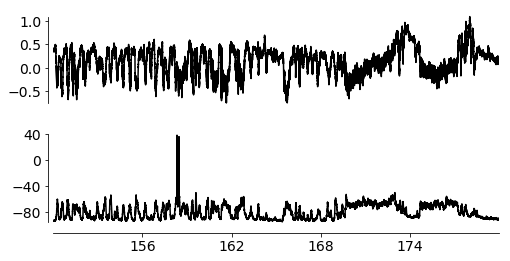

In [3]:
t0, length = 150, 30
cond = (t>t0) & (t<t0+length)
fig, AX = plt.subplots(2, figsize=(8,4))
AX[0].plot(t[cond], Extra[cond], 'k-')
set_plot(AX[0], ['left'], xticks=[], xlim=[t[cond][0], t[cond][-1]])
AX[1].plot(t[cond], Vm[cond], 'k-')
set_plot(AX[1], xlim=[t[cond][0], t[cond][-1]])

In [62]:
import numpy as np
import scipy
import scipy.signal
import scipy.optimize
import scipy.special
from scipy.misc import factorial

class Morlet(object):
    def __init__(self, w0=6):
        """w0 is the nondimensional frequency constant. If this is
        set too low then the wavelet does not sample very well: a
        value over 5 should be ok; Terrence and Compo set it to 6.
        """
        self.w0 = w0
        if w0 == 6:
            # value of C_d from TC98
            self.C_d = 0.776

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0, complete=True):
        """
        Complex Morlet wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        complete : bool
            Whether to use the complete or the standard version.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        See Also
        --------
        scipy.signal.gausspulse
        Notes
        -----
        The standard version::
            pi**-0.25 * exp(1j*w*x) * exp(-0.5*(x**2))
        This commonly used wavelet is often referred to simply as the
        Morlet wavelet.  Note that this simplified version can cause
        admissibility problems at low values of `w`.
        The complete version::
            pi**-0.25 * (exp(1j*w*x) - exp(-0.5*(w**2))) * exp(-0.5*(x**2))
        The complete version of the Morlet wavelet, with a correction
        term to improve admissibility. For `w` greater than 5, the
        correction term is negligible.
        Note that the energy of the return wavelet is not normalised
        according to `s`.
        The fundamental frequency of this wavelet in Hz is given
        by ``f = 2*s*w*r / M`` where r is the sampling rate.
        """
        w = self.w0

        x = t / s

        output = np.exp(1j * w * x)

        if complete:
            output -= np.exp(-0.5 * (w ** 2))

        output *= np.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)

        return output

    # Fourier wavelengths
    def fourier_period(self, s):
        """Equivalent Fourier period of Morlet"""
        return 4 * np.pi * s / (self.w0 + (2 + self.w0 ** 2) ** .5)

    def scale_from_period(self, period):
        """
        Compute the scale from the fourier period.
        Returns the scale
        """
        # Solve 4 * np.pi * scale / (w0 + (2 + w0 ** 2) ** .5)
        #  for s to obtain this formula
        coeff = np.sqrt(self.w0 * self.w0 + 2)
        return (period * (coeff + self.w0)) / (4. * np.pi)

    # Frequency representation
    def frequency(self, w, s=1.0):
        """Frequency representation of Morlet.
        Parameters
        ----------
        w : float
            Angular frequency. If `s` is not specified, i.e. set to 1,
            this can be used as the non-dimensional angular
            frequency w * s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given frequency
        """
        x = w * s
        # Heaviside mock
        Hw = np.array(w)
        Hw[w <= 0] = 0
        Hw[w > 0] = 1
        return np.pi ** -.25 * Hw * np.exp((-(x - self.w0) ** 2) / 2)

    def coi(self, s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return 2 ** .5 * s


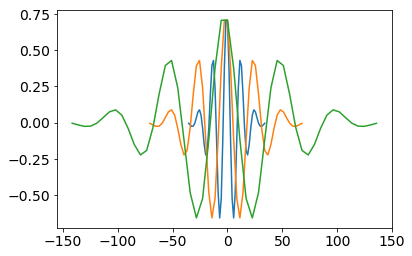

In [67]:
wavelet = Morlet(w0=6)
for s in [0.5, 1., 2.]:
    a = 2*wavelet.coi(s)
    plt.plot(a*(np.arange(50)-25), np.real(wavelet.time(t=np.linspace(-a,a), s=s)))

In [134]:

class Morlet(object):
    """
    adapted from: 

    """
    
    def __init__(self, w0=6):
        """w0 is the nondimensional frequency constant. If this is
        set too low then the wavelet does not sample very well: a
        value over 5 should be ok; Terrence and Compo set it to 6.
        """
        self.w0 = w0
        if w0 == 6:
            # value of C_d from TC98
            self.C_d = 0.776

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, f, complete=True):
        """
        Complex Morlet wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        complete : bool
            Whether to use the complete or the standard version.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        See Also
        --------
        scipy.signal.gausspulse
        Notes
        -----
        The standard version::
            pi**-0.25 * exp(1j*w*x) * exp(-0.5*(x**2))
        This commonly used wavelet is often referred to simply as the
        Morlet wavelet.  Note that this simplified version can cause
        admissibility problems at low values of `w`.
        The complete version::
            pi**-0.25 * (exp(1j*w*x) - exp(-0.5*(w**2))) * exp(-0.5*(x**2))
        The complete version of the Morlet wavelet, with a correction
        term to improve admissibility. For `w` greater than 5, the
        correction term is negligible.
        Note that the energy of the return wavelet is not normalised
        according to `s`.
        The fundamental frequency of this wavelet in Hz is given
        by ``f = 2*s*w*r / M`` where r is the sampling rate.
        """
        w = self.w0

        output = np.exp(2. * np.pi * 1j *  f * t)

        # if complete:
        #     output -= np.exp(-0.5 * (2. * np.pi * 1j *  f * t ** 2) / (w0 ** 2) )

        output *= np.exp(-0.5 * (2. * np.pi * 1j *  f * t ** 2) / (w ** 2) ) * np.pi ** (-0.25)

        return output

    # Fourier wavelengths
    def fourier_period(self, f):
        """Equivalent Fourier period of Morlet"""
        return 2. * self.w0 / f / (self.w0 + (2 + self.w0 ** 2) ** .5)

    def coi(self, f):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return 2. ** .5 / f * self.w0  / np.pi


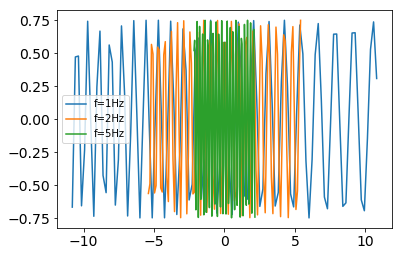

In [135]:
wavelet = Morlet(w0=6)
tt = np.linspace(-1, 1, 100)
dt = t[1]-t[0]
for f in [1, 2, 5]:
    a = 4.*wavelet.coi(f)
    plt.plot(a*tt,\
             np.real(wavelet.time(t=a*tt, f=f)), label='f='+str(f)+'Hz')
plt.legend()

In [5]:



def cwt(data, wavelet=None, widths=None, dt=1, frequency=False, axis=-1):
    """Continuous wavelet transform using the Fourier transform
    convolution as used in Terrence and Compo.
    (as opposed to the direct convolution method used by
    scipy.signal.cwt)
    *This method is over 10x faster than the scipy default.*
    Performs a continuous wavelet transform on `data`,
    using the `wavelet` function. A CWT performs a convolution
    with `data` using the `wavelet` function, which is characterized
    by a width parameter and length parameter.
    Parameters
    ----------
    data : (N,) ndarray
        data on which to perform the transform.
    wavelet : function
        Wavelet function in either time or frequency space, which
        should take 2 arguments. If the wavelet is frequency based,
        frequency must be set to True.
        The first parameter is time or frequency.
        The second is a width parameter, defining the size of the wavelet
        (e.g. standard deviation of a Gaussian).
        The wavelet function, Y, should be such that
        Int[-inf][inf](|Y|^2) = 1
        It is then multiplied here by a normalisation factor,
        which gives it unit energy.
        In the time domain, the normalisation factor is
            (s / dt)
        In the frequency domain, the normalisation factor is
            (2 * pi * dt / s) ^ (1/2),
    widths : (M,) sequence
        Widths to use for transform.
    dt: float
        sample spacing. defaults to 1 (data sample units).
    frequency: boolean. Whether the wavelet function is one of
               time or frequency. Default, False, is for a time
               representation of the wavelet function.
    axis: int, the axis in the data over which to perform the 1D
          transform (default 0)
    Returns
    -------
    cwt: (M, N) ndarray
        Will have shape of (len(data), len(widths)).
    """
    if widths is None:
        raise UserWarning('Have to specify some widths (scales)')

    if not wavelet:
        raise UserWarning('Have to specify a wavelet function')

    if frequency:
        return cwt_freq(data, wavelet, widths, dt, axis)
    elif not frequency:
        return cwt_time(data, wavelet, widths, dt, axis)


def cwt_time(data, wavelet, widths, dt, axis):
    # wavelets can be complex so output is complex
    output = np.zeros((len(widths),) + data.shape, dtype=np.complex)

    # compute in time
    slices = [None for _ in data.shape]
    slices[axis] = slice(None)
    for ind, width in enumerate(widths):
        # number of points needed to capture wavelet
        M = 10 * width / dt
        # times to use, centred at zero
        t = np.arange((-M + 1) / 2., (M + 1) / 2.) * dt
        # sample wavelet and normalise
        norm = (dt / width) ** .5
        wavelet_data = norm * wavelet(t, width)
        output[ind, :] = scipy.signal.fftconvolve(data,
                                                  wavelet_data[slices],
                                                  mode='same')
    return output


def cwt_freq(data, wavelet, widths, dt, axis):
    # compute in frequency
    # next highest power of two for padding
    N = data.shape[axis]
    pN = int(2 ** np.ceil(np.log2(N)))
    # N.B. padding in fft adds zeros to the *end* of the array,
    # not equally either end.
    fft_data = scipy.fft(data, n=pN, axis=axis)
    # frequencies
    w_k = np.fft.fftfreq(pN, d=dt) * 2 * np.pi

    # sample wavelet and normalise
    norm = (2 * np.pi * widths / dt) ** .5
    wavelet_data = norm[:, None] * wavelet(w_k, widths[:, None])

    # Convert negative axis. Add one to account for
    # inclusion of widths axis above.
    axis = (axis % data.ndim) + 1

    # perform the convolution in frequency space
    slices = [slice(None)] + [None for _ in data.shape]
    slices[axis] = slice(None)

    out = scipy.ifft(fft_data[None] * wavelet_data.conj()[slices],
                     n=pN, axis=axis)

    # remove zero padding
    slices = [slice(None) for _ in out.shape]
    slices[axis] = slice(None, N)

    if data.ndim == 1:
        return out[slices].squeeze()
    else:
        return out[slices]


class WaveletTransform(object):
    """
    Sx.y are references to section x.y in Torrence and Compo,
    A Practical Guide to Wavelet Analysis (BAMS, 1998)
    ### Wavelet function requirements (S3.b) ###
    To be admissible as a wavelet, a function must:
    - have zero mean
    - be localised in both time and frequency space
    These functions are a function of a dimensionless time
    parameter.
    ### Function selection considerations (S3.e) ###
    #### Complex / Real
    A *complex* wavelet function will return information about both
    amplitude and phase and is better adapted for capturing
    *oscillatory behaviour*.
    A *real* wavelet function returns only a single component and
    can be used to isolate *peaks or discontinuities*.
    ### Width
    Define the width of a wavelet as the e-folding time of the
    wavelet amplitude.
    The resolution of the wavelet function is determined by the
    balance between the width in real and Fourier space.
    A narrow function in time will have good time resolution but
    poor frequency resolution and vice versa.
    ### Shape
    The wavelet function should represent the type of features
    present in the time series.
    For time series with sharp jumps or steps, choose a boxcar-like
    function such as Harr; while for smoothly varying time series,
    choose something like a damped cosine.
    The choice of wavelet function is not critical if one is only
    qualitatively interested in the wavelet power spectrum.
    ### Equivalent Fourier period (S3.h) ###
    The peak wavelet response does not necessarily occur at 1 / s.
    If we wish to compare wavelet spectra at different scales with
    each other and with Fourier modes, we need a common set of
    units.
    The equivalent Fourier period is defined as where the wavelet
    power spectrum reaches its maximum and can be found analytically.
    """
    def __init__(self, data=None, time=None, dt=1,
                 dj=0.125, wavelet=Morlet(), unbias=False,
                 mask_coi=False, frequency=False, axis=-1):
        """Arguments:
            data - 1 dimensional input signal
            time - corresponding times for the input signal
                   not essential, but the COI will be calculated
                   for time starting at zero.
            dt - sample spacing
            dj - scale resolution
            wavelet - wavelet class to use, must have an attribute
                      `time`, giving a wavelet function that takes (t, s)
                      as arguments and, if frequency is True, an
                      attribute `frequency`, giving a wavelet function
                      that takes (w, s) as arguments.
            unbias - boolean, whether to unbias the power spectrum, as
                     in Liu et al. 2007 (default False)
            frequency - boolean, compute the cwt in frequency space?
                        (default False)
            mask_coi - disregard wavelet power outside the cone of
                       influence when computing global wavelet spectrum
                       (default False)
            axis - axis of the input data to transform over (default -1)
        """
        self.data = data
        if time is None:
            time = np.indices((data.shape[axis],)).squeeze() * dt
        self.time = time
        self.anomaly_data = self.data - self.data.mean(axis=axis,
                                                       keepdims=True)
        self.N = data.shape[axis]
        self.data_variance = self.data.var(axis=axis, keepdims=True)
        self.dt = dt
        self.dj = dj
        self.wavelet = wavelet
        # which continuous wavelet transform to use
        self.cwt = cwt
        self.frequency = frequency
        self.unbias = unbias
        self.mask_coi = mask_coi
        self.axis = axis

    @property
    def fourier_period(self):
        """Return a function that calculates the equivalent Fourier
        period as a function of scale.
        """
        return getattr(self.wavelet, 'fourier_period')

    @property
    def scale_from_period(self):
        """Return a function that calculates the wavelet scale
        from the fourier period
        """
        return getattr(self.wavelet, 'scale_from_period')

    @property
    def fourier_periods(self):
        """Return the equivalent Fourier periods for the scales used."""
        return self.fourier_period(self.scales)

    @fourier_periods.setter
    def fourier_periods(self, periods):
        """Set the scales based on a list of fourier periods"""
        self.scales = self.wavelet.scale_from_period(periods)

    @property
    def fourier_frequencies(self):
        """
        Return the equivalent frequencies .
        This is equivalent to 1.0 / self.fourier_periods
        """
        return np.reciprocal(self.fourier_periods)

    @fourier_frequencies.setter
    def fourier_frequencies(self, frequencies):
        """
        Set the scales based on a list of fourier periods.
        This is equivalent to self.fourier_periods = 1.0 / frequencies
        """
        self.fourier_periods = np.reciprocal(frequencies)

    @property
    def s0(self):
        if not hasattr(self, '_s0'):
            return self.find_s0()
        else:
            return self._s0

    @s0.setter
    def s0(self, value):
        setattr(self, '_s0', value)

    def find_s0(self):
        """Find the smallest resolvable scale by finding where the
        equivalent Fourier period is equal to 2 * dt. For a Morlet
        wavelet, this is roughly 1.
        """
        dt = self.dt

        def f(s):
            return self.fourier_period(s) - 2 * dt
        return scipy.optimize.fsolve(f, 1)[0]

    @property
    def scales(self):
        if not hasattr(self, '_scales'):
            return self.compute_optimal_scales()
        else:
            return self._scales

    @scales.setter
    def scales(self, value):
        setattr(self, '_scales', value)

    def compute_optimal_scales(self):
        """Form a set of scales to use in the wavelet transform.
        For non-orthogonal wavelet analysis, one can use an
        arbitrary set of scales.
        It is convenient to write the scales as fractional powers of
        two:
            s_j = s_0 * 2 ** (j * dj), j = 0, 1, ..., J
            J = (1 / dj) * log2(N * dt / s_0)
        s0 - smallest resolvable scale
        J - largest scale
        choose s0 so that the equivalent Fourier period is 2 * dt.
        The choice of dj depends on the width in spectral space of
        the wavelet function. For the Morlet, dj=0.5 is the largest
        that still adequately samples scale. Smaller dj gives finer
        scale resolution.
        """
        dt = self.dt
        # resolution
        dj = self.dj
        # smallest resolvable scale, chosen so that the equivalent
        # Fourier period is approximately 2dt
        s0 = self.s0

        # Largest scale
        J = int((1 / dj) * np.log2(self.N * dt / s0))

        sj = s0 * 2 ** (dj * np.arange(0, J + 1))
        return sj

    @property
    def w_k(self):
        """Angular frequency as a function of Fourier index.
        See eq5 of TC.
        N.B the frequencies returned by numpy are adimensional, on
        the interval [-1/2, 1/2], so we multiply by 2 * pi.
        """
        return 2 * np.pi * np.fft.fftfreq(self.N, self.dt)

    @property
    def wavelet_transform(self):
        """Calculate the wavelet transform."""
        widths = self.scales

        if self.frequency:
            wavelet = self.wavelet.frequency
        else:
            wavelet = self.wavelet.time

        return self.cwt(self.anomaly_data,
                        wavelet=wavelet,
                        widths=widths,
                        dt=self.dt,
                        frequency=self.frequency,
                        axis=self.axis)

    @property
    def wavelet_power(self):
        """Calculate the wavelet power spectrum, optionally using
        the bias correction factor introduced by Liu et al. 2007,
        which is to divide by the scale.
        """
        if self.unbias:
            return (np.abs(self.wavelet_transform).T ** 2 / self.scales).T
        elif not self.unbias:
            return np.abs(self.wavelet_transform) ** 2

    def reconstruction(self, scales=None):
        """Reconstruct the original signal from the wavelet
        transform. See S3.i.
        For non-orthogonal wavelet functions, it is possible to
        reconstruct the original time series using an arbitrary
        wavelet function. The simplest is to use a delta function.
        The reconstructed time series is found as the sum of the
        real part of the wavelet transform over all scales,
        x_n = (dj * dt^(1/2)) / (C_d * Y_0(0)) \
                * Sum_(j=0)^J { Re(W_n(s_j)) / s_j^(1/2) }
        where the factor C_d comes from the reconstruction of a delta
        function from its wavelet transform using the wavelet
        function Y_0. This C_d is a constant for each wavelet
        function.
        """
        dj = self.dj
        dt = self.dt
        C_d = self.C_d
        Y_00 = self.wavelet.time(0)
        if scales is not None:
            old_scales = self.scales
            self.scales = scales

        s = self.scales
        W_n = self.wavelet_transform

        if scales is not None:
            self.scales = old_scales

        # use the transpose to allow broadcasting
        real_sum = np.sum(W_n.real.T / s ** .5, axis=-1).T
        x_n = real_sum * (dj * dt ** .5 / (C_d * Y_00))

        # add the mean back on (x_n is anomaly time series)
        x_n += self.data.mean(axis=self.axis, keepdims=True)

        return x_n

    @property
    def global_wavelet_spectrum(self):
        if not self.mask_coi:
            mean_power = np.mean(self.wavelet_power, axis=1)
        elif self.mask_coi:
            mean_power = self.coi_mean(self.wavelet_power, axis=1)
        var = self.data_variance
        return mean_power / var

    def coi_mean(self, arr, axis=1):
        """Calculate a mean, but only over times within the cone of
        influence.
        Implement so can replace np.mean(wavelet_power, axis=1)
        """
        # TODO: consider applying upstream, inside wavelet_power
        coi = self.wavelet.coi
        s = self.scales
        t = self.time
        T, S = np.meshgrid(t, s)
        inside_coi = (coi(S) < T) & (T < (T.max() - coi(S)))
        mask_power = np.ma.masked_where(~inside_coi, self.wavelet_power)
        mask_mean = np.mean(mask_power, axis=axis)
        return mask_mean

    @property
    def C_d(self):
        """Constant used in reconstruction of data from delta
        wavelet function. See self.reconstruction and S3.i.
        To derive C_d for a new wavelet function, first assume a
        time series with a delta function at time n=0, given by x_n
        = d_n0. This time series has a Fourier transform x_k = 1 /
        N, constant over k.
        Substituting x_k into eq4 at n=0 (the peak of the delta
        function), the wavelet transform becomes
            W_d(s) = (1 / N) Sum[k=0][N-1] { Y'*(s, w_k) }
        The reconstruction then gives
            C_d = (dj * dt^(1/2)) / Y_0(0) \
                    * Sum_(j=0)^J { Re(W_d(s_j)) / s_j^(1/2) }
        C_d is scale independent and a constant for each wavelet
        function.
        """
        if hasattr(self.wavelet, 'C_d'):
            return self.wavelet.C_d
        else:
            return self.compute_Cdelta()

    def compute_Cdelta(self):
        """Compute the parameter C_delta (see self.C_d), used in
        reconstruction. See section 3.i of TC98.
        FIXME: this doesn't work. TC98 gives 0.776 for the Morlet
        wavelet with dj=0.125.
        """
        dj = self.dj
        dt = self.dt
        s = self.scales
        W_d = self.wavelet_transform_delta

        # value of the wavelet function at t=0
        Y_00 = self.wavelet.time(0)

        real_sum = np.sum(W_d.real / s ** .5)
        C_d = real_sum * (dj * dt ** .5 / Y_00)
        return C_d

    @property
    def wavelet_transform_delta(self):
        """Calculate the delta wavelet transform.
        Returns an array of the transform computed over the scales.
        """
        Y_0 = self.wavelet.frequency  # wavelet as f(w_k, s)

        WK, S = np.meshgrid(self.w_k, self.scales)

        # compute Y_ over all s, w_k and sum over k
        norm = (2 * np.pi * S / self.dt) ** .5
        W_d = (1 / self.N) * np.sum(norm * Y_0(WK, S), axis=1)

        # N.B This W_d is 1D (defined only at n=0)
        return W_d

    @property
    def wavelet_variance(self):
        """Equivalent of Parseval's theorem for wavelets, S3.i.
        The wavelet transform conserves total energy, i.e. variance.
        Returns the variance of the input data.
        """
        # TODO: mask COI for calculation of wavelet_variance
        # is this possible? how does it change the factors?
        dj = self.dj
        dt = self.dt
        C_d = self.C_d
        N = self.N
        s = np.expand_dims(self.scales, 1)

        A = dj * dt / (C_d * N)

        var = A * np.sum(np.abs(self.wavelet_transform) ** 2 / s)

        return var

    @property
    def coi(self):
        """The Cone of Influence is the region near the edges of the
        input signal in which edge effects may be important.
        Return a tuple (T, S) that describes the edge of the cone
        of influence as a single line in (time, scale).
        """
        Tmin = self.time.min()
        Tmax = self.time.max()
        Tmid = Tmin + (Tmax - Tmin) / 2
        s = np.logspace(np.log10(self.scales.min()),
                        np.log10(self.scales.max()),
                        100)
        c1 = Tmin + self.wavelet.coi(s)
        c2 = Tmax - self.wavelet.coi(s)

        C = np.hstack((c1[np.where(c1 < Tmid)], c2[np.where(c2 > Tmid)]))
        S = np.hstack((s[np.where(c1 < Tmid)], s[np.where(c2 > Tmid)]))

        # sort w.r.t time
        iC = C.argsort()
        sC = C[iC]
        sS = S[iC]

        return sC, sS

    def plot_power(self, ax=None, coi=True):
        """Create a basic wavelet power plot with time on the
        x-axis, scale on the y-axis, and a cone of influence
        overlaid.
        Requires matplotlib.
        """
        import matplotlib.pyplot as plt

        if not ax:
            fig, ax = plt.subplots()

        Time, Scale = np.meshgrid(self.time, self.scales)
        ax.contourf(Time, Scale, self.wavelet_power, 100)

        ax.set_yscale('log')
        ax.grid(True)

        if coi:
            coi_time, coi_scale = self.coi
            ax.fill_between(x=coi_time,
                            y1=coi_scale,
                            y2=self.scales.max(),
                            color='gray',
                            alpha=0.3)

        ax.set_xlim(self.time.min(), self.time.max())

        return ax

In [13]:
#given a signal x(t)
x = Extra[cond]
# and a sample spacing
dt = t[1]-t[0]
wa = WaveletTransform(x, dt=dt)
# wavelet power spectrum
power = wa.wavelet_power
# scales 
scales = wa.scales
# associated time vector
tt = wa.time
# reconstruction of the original data
rx = wa.reconstruction()

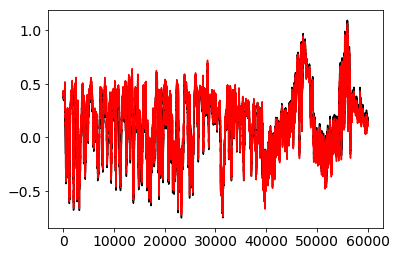

In [16]:
plt.plot(tt, x, 'k-')
plt.plot(tt, np.real(rx), 'r-')

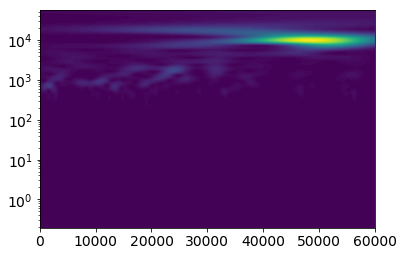

In [18]:
fig, ax = plt.subplots()
T, S = np.meshgrid(tt, scales)
ax.contourf(T, S, power, 100)
ax.set_yscale('log')